In [1]:
%load_ext autoreload
%autoreload 2

# Feature engineering - results analysis

In [2]:
import wandb
import pandas as pd

import plotly.io as pio
pio.renderers.default = 'iframe'

In [3]:
from wnb_logging import FEATURE_NAMES

# Initial results analysis

## Loading data from W&B

In [4]:
from wnb_logging import download_df_between_the_timestamps

first_valid_run_name = "neat-mountain-74"
last_valid_run_name = "generous-rain-261"

runs_df, metric_columns = download_df_between_the_timestamps(first_valid_run_name, last_valid_run_name)

In [5]:
runs_df[["n_estimators", "texture_window"]].value_counts()

n_estimators  texture_window
10            5                 62
100           5                 62
              10                62
Name: count, dtype: int64

## Reslults analysis

In [6]:
from plot_results import plot_scores

### A larger amount of features improves the segmentation performance

In [7]:
plot_scores(runs_df, n_estimators=100, texture_window=10, metric_columns=metric_columns)

In [8]:
plot_scores(runs_df, n_estimators=100, texture_window=5, metric_columns=metric_columns)

In [9]:
plot_scores(runs_df, n_estimators=10, texture_window=5, metric_columns=metric_columns)

In general, we can see increasing trend of metrics values with respect to the number of features. However, after analysis of DICE score for each class we can see that the biggest impact the number of features has on GreyMatter and WhiteMatter, that have quite big DICE scores, so their contribution to mean DICE is bigger than for other classes.

Additionally, here we consider only the number of the features, but the combinations are different, and also the number of samples is different (e.g. only one sample for all the features activated).

In [10]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

runs_df['n_estimators_and_texture_window'] = (
    runs_df['n_estimators'].astype(str) + '&' + runs_df['texture_window'].astype(str)
)

grouped_df = runs_df.groupby(FEATURE_NAMES + ['n_estimators_and_texture_window'])['MEAN_DICE'].mean().reset_index()

pivot_df = grouped_df.pivot(
    index=FEATURE_NAMES,
    columns='n_estimators_and_texture_window',
    values='MEAN_DICE'
).reset_index()

pivot_df = pivot_df.sort_values("100&5").reset_index()


fig = go.Figure()

n_estimators_columns = [col for col in pivot_df.columns if col not in FEATURE_NAMES + ["index"]]

for col in n_estimators_columns:
    fig.add_trace(
        go.Scatter(
            x=pivot_df.index,
            y=pivot_df[col],
            mode='markers',
            name=col
        )
    )

fig.update_layout(
    title="MEAN_Dice for each n_estimators_and_texture_window",
    xaxis_title="Feature Combination",
    yaxis_title="MEAN_Dice",
    legend_title="n_estimators_and_texture_window",
)

fig.show()

### Feature importance analysis

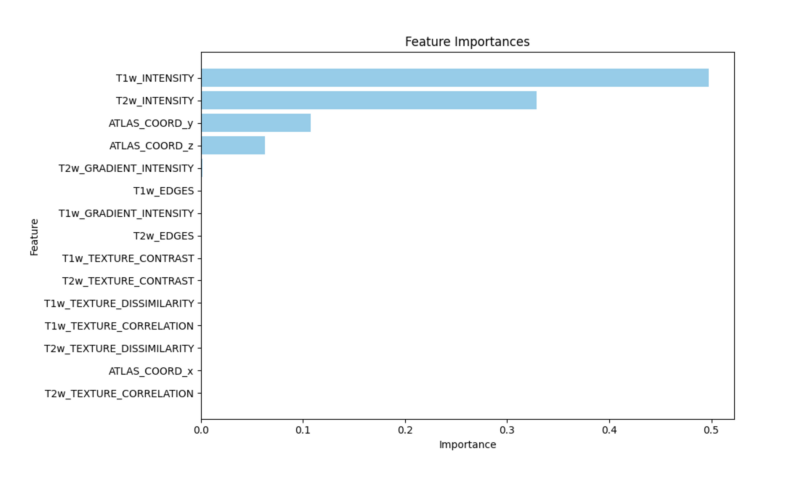

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(f"mia-result/g85vwre9_feature_importances.png")
plt.figure(figsize=(10, 10)) 
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

From the analysis of the feature importances we can see that the intensity of T1w and T2w are the most important for the model.

## Analysis of the performance after grouping the classes 

In [12]:
first_valid_run_name = "vibrant-puddle-263"
last_valid_run_name = "chocolate-terrain-325"

runs_df_with_d_and_h, metric_columns = download_df_between_the_timestamps(first_valid_run_name, last_valid_run_name)

In [13]:
runs_df_with_d_and_h[["n_estimators", "texture_window"]].value_counts()

n_estimators  texture_window
100           5.0               61
Name: count, dtype: int64

In [14]:
# Fix some issues with logged values

runs_df_with_d_and_h = runs_df_with_d_and_h.replace("Infinity", None)

hdrdst_per_segment_columns = [c for c in runs_df_with_d_and_h.columns if "MEAN_HDRFDST_" in c]
runs_df_with_d_and_h["MEAN_HDRFDST"] = runs_df_with_d_and_h[hdrdst_per_segment_columns].mean(axis=1)

In [15]:
hdrdst_columns = [c for c in metric_columns if "HDRFDST" in c]
df_long = plot_scores(runs_df_with_d_and_h, n_estimators=100, texture_window=5, metric_columns=hdrdst_columns)